# Prediction of SanFrancisco city employee compensation: Part 1 - Data Munging

## Objective: 
The objective of this work is to predict the annual base salary of SanFrancisco (SF) city employee.


## Background: 

To predict the base salary of SF city employee, SF employee compensation dataset is used (https://data.sfgov.org/City-Management-and-Ethics/Employee-Compensation/88g8-5mnd). The dataset contains the amount of salaries and benefits paid to city employees every fiscal year. The dataset contains employee compensation from 2013 - 2017. More details about the dataset can be obtained here: https://data.sfgov.org/api/views/88g8-5mnd/files/OMBVvreoXRjXG6oP4Ts4497dNxt14XlBqB6uIL6cq-o?download=true&filename=N:\EIS\DataCoordination\Metadata%20Spring%20Cleaning\CON_DataDictionary_Employee-Compensation.pdf

## Content

1. Understanding Data
2. Cleaning Data
    1. Drop duplicated columns
    2. Rename column names
    3. Removing all records which have negative salaries and benefits
    4. Removing records with base salary below a threshold set by SF minimum wage
    5. Removing records for which there are more than 1 job reported per year per employee ID
    6. Dealing missing values


### 1. Understanding Data

- There are 213202 observations with 22 columns of data types object, int64 and float 64. 
- 0.1% of observations were found missing in columns Union, Union Code, Job Family and Job Family Code.

In [25]:
#Import required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn

In [26]:
# Reading the csv file into a pandas dataframe
df = pd.read_csv("Employee_compensation.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213202 entries, 0 to 213201
Data columns (total 22 columns):
Year Type                  213202 non-null object
Year                       213202 non-null int64
Organization Group Code    213202 non-null int64
Organization Group         213202 non-null object
Department Code            213202 non-null object
Department                 213202 non-null object
Union Code                 212987 non-null float64
Union                      212987 non-null object
Job Family Code            212982 non-null object
Job Family                 212982 non-null object
Job Code                   213202 non-null object
Job                        213202 non-null object
Employee Identifier        213202 non-null int64
Salaries                   213202 non-null float64
Overtime                   213202 non-null float64
Other Salaries             213202 non-null float64
Total Salary               213202 non-null float64
Retirement                 213202 non

In [27]:
# % missing records 
print("% missing records in column 'Union':", (df.Union.isnull().sum()/df.shape[0])*100)
print("% missing records in column 'Job Family':", (df['Job Family'].isnull().sum()/df.shape[0])*100)

% missing records in column 'Union': 0.10084333167606307
% missing records in column 'Job Family': 0.10318852543597151


From sampling the dataframe, it is clear that there are some duplicated columns:
    
1. Columns Organization, Department, Union, Job Family and Job has a numerical/abbreviated version reported in Organization code, Department code, Union code, Job Family code and Job code. So either one of the two columns can be dropped for data analysis/modeling.
2. Some columns are addition of two or more columns:   
    - Total Salary = Salaries + Overtime + Other Salaries
    - Total Benefits = Retirement + Health/Dental + Other Benefits
    - Total Compensation = Total Salary + Total Benefits
*The city's documentation on this dataset also provides the same information

In [28]:
df.sample(7)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
181242,Fiscal,2017,6,General Administration & Finance,CON,CON Controller,790.0,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",...,22900,80727.35,1379.46,830.43,82937.24,14830.80,13765.55,7166.78,35763.13,118700.37
129832,Fiscal,2016,6,General Administration & Finance,TIS,DT GSA - Technology,790.0,"SEIU - Miscellaneous, Local 1021",7300,Journeyman Trade,...,48749,12813.50,0.00,763.32,13576.82,0.00,1760.15,229.15,1989.30,15566.12
20041,Fiscal,2014,2,"Public Works, Transportation & Commerce",DPW,DPW GSA - Public Works,216.0,"Teamsters, Local 853",7300,Journeyman Trade,...,34851,1655.40,0.00,44.83,1700.23,0.00,287.74,131.63,419.37,2119.60
115138,Fiscal,2015,1,Public Protection,POL,POL Police,911.0,Police Officers' Association,Q000,Police Services,...,3114,118840.88,24222.61,14884.13,157947.62,26253.61,12447.58,2614.80,41315.99,199263.61
153335,Fiscal,2015,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,253.0,"Transport Workers - Transit Operators, Local 2...",9100,Street Transit,...,39994,66332.92,14248.84,4003.52,84585.28,20887.09,13305.85,6603.64,40796.58,125381.86
52260,Fiscal,2015,6,General Administration & Finance,TTX,TTX Treasurer/Tax Collector,790.0,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",...,28321,34225.11,119.90,0.00,34345.01,8830.11,8986.92,2794.84,20611.87,54956.88
81925,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,...,12203,133939.69,0.00,10175.96,144115.65,21676.96,12498.47,2653.51,36828.94,180944.59


## 2A. Drop duplicated columns and Year Type column

- Organization Group code corresponds to a particular organization group. One of these columns can be dropped. Same for department and department code, union and union code, Job family and job family code, and job and job code.

- *Year Type:* Has only one unique value - 'Fiscal'. Employee's compensation can be reported by annual calendar or fiscal year. This column shows that San Francisco city reports all its employee compensation by Fiscal year. This column can be eliminated for data analysis/modeling.

In [29]:
df.drop(['Year Type','Organization Group Code','Department Code', 'Union Code', 'Job Family Code', 'Job Code'], 1, inplace = True)

## 2B. Rename column names 

Renaming columns for better readability and usage in coding

In [30]:
# Rename columns by replacing space with underscore
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("/", "_")
df.columns

Index(['Year', 'Organization_Group', 'Department', 'Union', 'Job_Family',
       'Job', 'Employee_Identifier', 'Salaries', 'Overtime', 'Other_Salaries',
       'Total_Salary', 'Retirement', 'Health_Dental', 'Other_Benefits',
       'Total_Benefits', 'Total_Compensation'],
      dtype='object')

In [31]:
df.describe(include='all')

,Year,Organization_Group,Department,Union,Job_Family,Job,Employee_Identifier,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health_Dental,Other_Benefits,Total_Benefits,Total_Compensation
count,213202.000000,213202,213202,212987,212982,213202,213202.000000,213202.000000,213202.000000,213202.000000,213202.000000,213202.000000,213202.000000,213202.000000,213202.000000,213202.000000
unique,NaN,7,56,77,57,1162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,"Public Works, Transportation & Commerce",DPH Public Health,"SEIU - Miscellaneous, Local 1021",Nursing,Transit Operator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,67289,46121,60811,21856,13089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015.073419,NaN,NaN,NaN,NaN,NaN,28504.107152,63818.588137,4510.403115,3744.676396,72073.667649,12623.468197,9054.335274,4721.222929,26399.026400,98472.694049
std,1.411026,NaN,NaN,NaN,NaN,NaN,16470.647243,45437.255368,11328.050867,7508.717668,53020.015944,9662.663863,5027.354210,3933.456459,16904.667254,68691.650142
min,2013.000000,NaN,NaN,NaN,NaN,NaN,1.000000,-68771.780000,-12308.660000,-19131.100000,-68771.780000,-28723.190000,-2946.530000,-9857.740000,-19814.440000,-74082.610000
25%,2014.000000,NaN,NaN,NaN,NaN,NaN,14219.000000,23165.535000,0.000000,0.000000,25100.687500,3204.380000,4272.070000,1578.132500,9302.352500,35380.337500
50%,2015.000000,NaN,NaN,NaN,NaN,NaN,28507.500000,63210.840000,0.000000,690.715000,68641.710000,12837.990000,12132.890000,4395.385000,30311.045000,98783.275000
75%,2016.000000,NaN,NaN,NaN,NaN,NaN,42839.000000,93215.010000,2872.012500,4536.872500,104364.957500,19117.240000,12828.707500,6950.227500,38497.887500,143207.460000


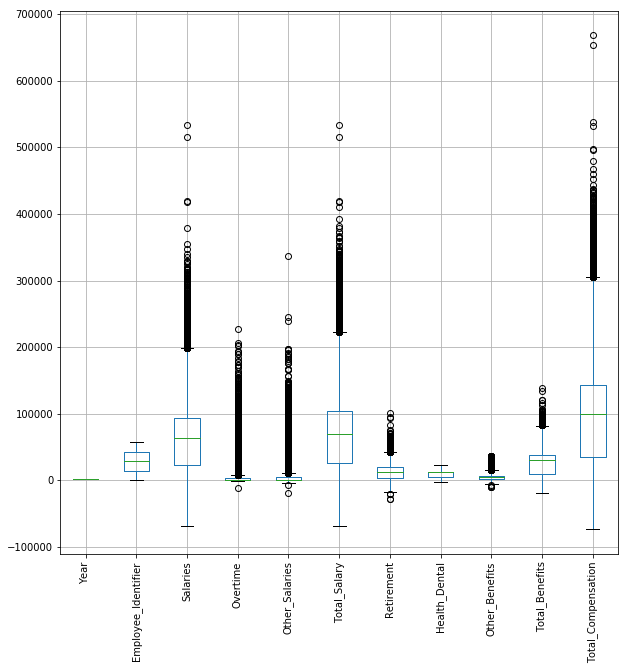

In [32]:
# Visualization of distribution data
df.boxplot(figsize=(10,10), rot = 90)
plt.show()

## 2C. Removing all records which have negative salaries and benefits
Box plot clearly indicates that all the columns related to salaries and benefits have negative value. Let us look at the distribution of every one of this column.

Observations:
1. On the whole, only small amount (<<25%) of data are found below \$0.00 (Exact amount calculated in the next cell).
2. Shape of histograms of columns Salaries, Total_compensation and Total Salary - look alike. All three of them have a peak aound \$60,000 and another half peak around $0.00 -> Does that mean Salaries is the dominating factor for total compensation? 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b9f96a0>,
      dtype=object)

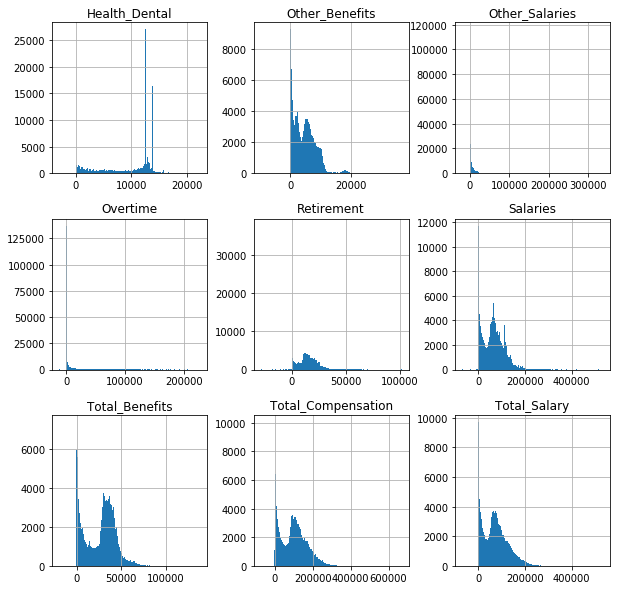

In [33]:
df.loc[:,'Salaries':].hist(bins = 300, figsize = (10,10))

### How much of data are present below USD 0.00?

Percentage of data found below $0.00 in the whole database: 0.4% *(% rows with value < 0 in any column)*

Percentage of data below zero in every columns is 

In [34]:
print("Percentage of observations found below $0.00")
df.loc[:,'Salaries':].apply(lambda x: ((x < 0).sum()/(x.count()))*100)

Percentage of observations found below $0.00


Salaries              0.040337
Overtime              0.015009
Other_Salaries        0.030488
Total_Salary          0.025328
Retirement            0.148216
Health_Dental         0.066134
Other_Benefits        0.184801
Total_Benefits        0.158535
Total_Compensation    0.098498
dtype: float64

In [35]:
# If we eliminate all rows with any negative values, how many rows do we eliminate? What is the percentage of data we loose?
neg_rows = df.query('Salaries < 0 or Overtime < 0 or Other_Salaries < 0 or Total_Salary < 0 or Retirement < 0 or Other_Benefits < 0 or Total_Benefits < 0 or Total_Compensation < 0 or Health_Dental < 0').shape[0]
neg_rows_percent = (neg_rows/df.shape[0])*100
print("Number of records with negatitive salary or benefits:", neg_rows)
print("Percentage of records with negatitive salary or benefits:", neg_rows_percent)

Number of records with negatitive salary or benefits: 860
Percentage of records with negatitive salary or benefits: 0.4033733267042523


/Users/PrakashNREL/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/PrakashNREL/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/PrakashNREL/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


Text(0.5,0,'Compensation (US $)')

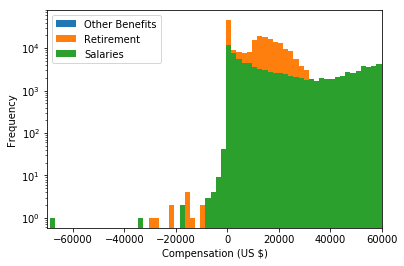

In [36]:
# How does the value below zero got distributed?
df.loc[:,['Other Benefits', 'Retirement','Salaries']].plot(kind = 'hist', bins=300, logy = True, xlim = (-70000,60000))
plt.xlabel("Compensation (US $)")

### Drop all rows where numerical column value < 0

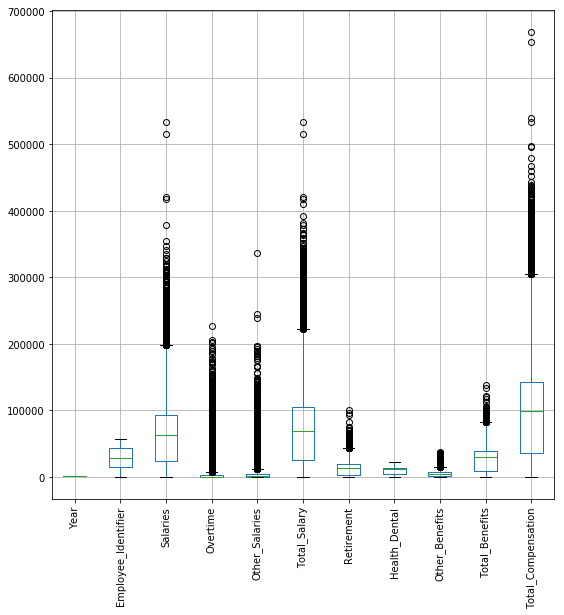

In [37]:
df.query('Salaries >= 0 and Overtime >= 0 and Other_Salaries >= 0 and Total_Salary >= 0 and Retirement >= 0 and Other_Benefits >= 0 and Total_Benefits >= 0 and Total_Compensation >= 0 and Health_Dental >= 0', inplace = True)
df.boxplot(figsize = (9,9), rot= 90)

Median of base salary in SF city (2013 - 2017): $ 63270.92


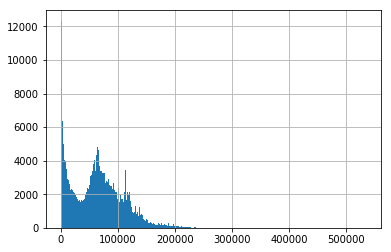

In [38]:
df.Salaries.hist(bins=300)
print("Median of base salary in SF city (2013 - 2017): $", df.Salaries.median())

## 2D. Removing records with base salary below a threshold set by SF minimum wage

Observation from salary distribution:

1. Median of the 'Salaries' is $63,270.92. Compared to the raw data (Salaries median: 63210.84), the median has increased by 5% 

2. Two peaks observed indicating bimodal signature. The first peak with the highest count at $0.00 could represent employees who may have been volunteers, part time workers, employee on absence or others. 

Our goal is to predict an employee's annual base salary and therefore these records can introduce bias in our model. To address this, records with base salary lower than San Francisco's Minimum Wage amount can be removed.  
San Francisco's Minimum Wage per hour is as follows as per [link](https://ballotpedia.org/City_of_San_Francisco_Minimum_Wage_Increase_Referred_Measure,_Proposition_J_(November_2014)

| Year | Minimum wage per hour | Minimum wage per annum |
| ---- | --------------------- | ---------------------- |
| 2013 | 10.55                 | 21,944                 |
| 2014 | 12.25                 | 25,480                 |
| 2015 | 13.00                 | 27,040                 |
| 2016 | 13.00                 | 27,040                 |
| 2017 | 14.00                 | 29,120                 |

Minimum wage per annum = 52 weeks * 40 hours * Minimum wage per hour

In [39]:
# Removing records whose base salary is less than the minimum annual wage
df.query('(Year == 2013 and Salaries > 21900) or (Year == 2014 and Salaries > 25480) or (Year == 2015 and Salaries > 27040) or (Year == 2016 and Salaries > 27040) or (Year == 2017 and Salaries > 29120)', inplace = True)

In [40]:
df.describe(include = 'all')

,Year,Organization_Group,Department,Union,Job_Family,Job,Employee_Identifier,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health_Dental,Other_Benefits,Total_Benefits,Total_Compensation
count,156173.000000,156173,156173,156130,156125,156173,156173.000000,156173.000000,156173.000000,156173.000000,156173.000000,156173.000000,156173.000000,156173.000000,156173.000000,156173.000000
unique,NaN,7,56,73,57,1120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,"Public Works, Transportation & Commerce",DPH Public Health,"SEIU - Miscellaneous, Local 1021",Nursing,Transit Operator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,52853,34565,36108,15139,10502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015.057949,NaN,NaN,NaN,NaN,NaN,28465.192236,83733.906506,6053.160898,4710.992815,94498.060219,16797.168927,11606.660012,6141.324695,34545.153634,129043.213853
std,1.421159,NaN,NaN,NaN,NaN,NaN,16481.966985,36155.346167,12868.335505,7654.545979,43740.447395,7789.757202,2906.382035,3642.030754,11643.049213,53601.200969
min,2013.000000,NaN,NaN,NaN,NaN,NaN,1.000000,21906.330000,0.000000,0.000000,21927.250000,0.000000,0.000000,0.000000,54.880000,23145.080000
25%,2014.000000,NaN,NaN,NaN,NaN,NaN,14159.000000,58121.200000,0.000000,0.000000,62669.510000,11759.270000,11189.450000,3643.380000,28672.510000,91169.630000
50%,2015.000000,NaN,NaN,NaN,NaN,NaN,28423.000000,76401.730000,81.740000,1600.000000,85082.930000,15921.770000,12516.720000,5698.500000,34646.660000,119933.940000
75%,2016.000000,NaN,NaN,NaN,NaN,NaN,42841.000000,106253.810000,6027.200000,6509.080000,119899.600000,21278.340000,13175.970000,7897.160000,41040.150000,161738.260000


Now, the base salary distribution is unimodal and postively skewed as expected. 
The median of the base salary is increased to $ 76386.31 (decreased by ??% from raw data)

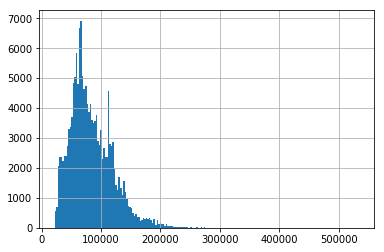

In [41]:
# Histogram of salaries after 
df.Salaries.hist(bins=200)

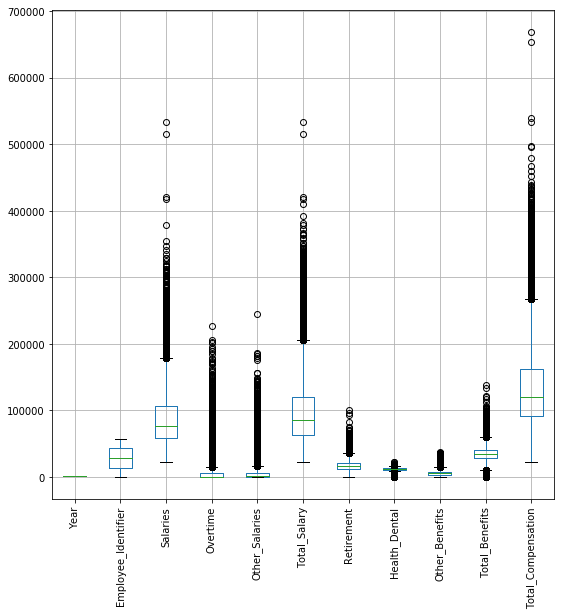

In [42]:
df.boxplot(rot=90, figsize =(9,9))

### 2E. Removing records for which there are more than 1 job reported per year per employee ID

The dataset contains annual employee compensation for the year 2013 - 2017. So, ideally there should be only 5 records per employee ID. Some records were found where one employee ID has more than one job per year. This could be due to promotion or job change. Since our goal is to predict annual base salary for an employee with a particular job title in a department and organization, this could lead to bias. So, we can remove all records where more than one job is reported in a fiscal year. This resulted in ~30% los of data.

In [43]:
print("Employee ID and number of records in the database:", df.Employee_Identifier.value_counts().nlargest(10))
df.query('Employee_Identifier == 17726').sort_values('Year')

Employee ID and number of records in the database: 17726    11
34440     9
4611      9
18963     8
14160     8
34918     8
44009     8
45729     8
45049     8
18212     8
Name: Employee_Identifier, dtype: int64


,Year,Organization_Group,Department,Union,Job_Family,Job,Employee_Identifier,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health_Dental,Other_Benefits,Total_Benefits,Total_Compensation
22651,2013,Public Protection,POL Police,Police Officers' Association,Police Services,Lieutenant (Police Department),17726,24248.01,0.00,29257.38,53505.39,4318.04,1973.57,829.97,7121.58,60626.97
90482,2013,Public Protection,POL Police,Police Officers' Association,Police Services,Lieutenant 3,17726,59104.53,4837.66,10886.60,74828.79,10559.40,4810.56,1230.05,16600.01,91428.80
186655,2013,Public Protection,POL Police,Police Officers' Association,Police Services,Inspector 3,17726,66488.66,30805.52,9735.43,107029.61,11844.98,6167.39,1704.09,19716.46,126746.07
33917,2014,Public Protection,POL Police,Police Officers' Association,Police Services,Lieutenant 3,17726,156702.75,8467.37,18438.81,183608.93,32644.60,12396.83,2958.38,47999.81,231608.74
7914,2015,Public Protection,POL Police,Police Officers' Association,Police Services,Commander 3,17726,39465.91,0.00,6185.69,45651.60,8670.57,2251.22,763.29,11685.08,57336.68
33760,2015,Public Protection,POL Police,Police Officers' Association,Police Services,Lieutenant 3,17726,129726.87,52671.18,3283.72,185681.77,28540.97,10250.24,3090.77,41881.98,227563.75
49978,2016,Public Protection,POL Police,Police Officers' Association,Police Services,Commander 3,17726,146721.30,0.00,3480.07,150201.37,26510.52,8700.16,2539.53,37750.21,187951.58
184199,2016,Public Protection,POL Police,Police Officers' Association,Police Services,Deputy Chief 3,17726,87994.05,0.00,3066.01,91060.06,15884.99,3922.61,7038.20,26845.80,117905.86
53432,2017,Public Protection,POL Police,Municipal Executive Association - Police,Management,Chief Of Police,17726,139980.12,0.00,3146.54,143126.66,24715.05,5801.57,11090.47,41607.09,184733.75
58849,2017,Public Protection,POL Police,Municipal Executive Association - Police,Police Services,Assistant Chief Of Police,17726,135236.01,0.00,3083.20,138319.21,23873.92,6328.98,12086.30,42289.20,180608.41


In [44]:
# Removing all records where Employee ID has more than 1 job in a fiscal year. This reduces the number of observations to 185213

df_final = df.groupby(['Employee_Identifier', 'Year']).filter(lambda x: x['Year'].count() < 2)

In [46]:
# % rows lost from original data

(213202 - df_final.shape[0])/(213202)*100

30.117447303496213

### 2F. Dealing with missing values

Union and Job_Family has 34 and 37 null values. Fill them with "NA"

In [47]:
df_final.fillna('NA', inplace = True)

/Users/PrakashNREL/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [48]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148991 entries, 0 to 213201
Data columns (total 16 columns):
Year                   148991 non-null int64
Organization_Group     148991 non-null object
Department             148991 non-null object
Union                  148991 non-null object
Job_Family             148991 non-null object
Job                    148991 non-null object
Employee_Identifier    148991 non-null int64
Salaries               148991 non-null float64
Overtime               148991 non-null float64
Other_Salaries         148991 non-null float64
Total_Salary           148991 non-null float64
Retirement             148991 non-null float64
Health_Dental          148991 non-null float64
Other_Benefits         148991 non-null float64
Total_Benefits         148991 non-null float64
Total_Compensation     148991 non-null float64
dtypes: float64(9), int64(2), object(5)
memory usage: 19.3+ MB


In [49]:
%store df_final

Stored 'df_final' (DataFrame)
